In [121]:
from itertools import cycle
import numpy as np
import pandas as pd
from sklearn.linear_model import lasso_path
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LassoCV
import matplotlib.gridspec as gridspec


In [122]:
random.seed(93)
np.random.seed(93)
sqft_train = pd.read_csv("sqft_test.csv")
sqft_test = pd.read_csv("sqft_test.csv")
print(sqft_train.columns)

Index(['air.level', 'base.num', 'baths', 'beds', 'busi.level', 'covered.fee',
       'garage.fee', 'has.covered', 'has.garage', 'has.lot', 'has.street',
       'lot.fee', 'neighborhood', 'pet.allowed', 'pet.deposit', 'pet.fee',
       'pet.rent', 'shopping.num', 'sqft', 'traffic.level', 'zip', 'lat',
       'lng', 'has.parking', 'bed_count', 'bath_count', 'has.pub.elementary',
       'has.priv.elementary', 'has.pub.mid', 'has.cha.high', 'has.priv.high',
       'count.pub.high', 'pub.elt.mid', 'priv.elt.mid', 'has.cha.mid.high',
       'has.priv.mid.high', 'has.pub.mid.high', 'priv.el.hi', 'cha.elt.mid.hi',
       'priv.elt.mid.hi', 'PC1', 'PC2', 'PC3', 'PC4'],
      dtype='object')


In [123]:
sqft_tr_X = sqft_train.loc[:, sqft_train.columns != "sqft"]
sqft_tr_Y = sqft_train.loc[:, "sqft"]
sqft_ts_X = sqft_test.loc[:, sqft_test.columns != "sqft"]
sqft_ts_Y = sqft_test.loc[:, "sqft"]

categories = [
    'air.level', 'base.num', 'busi.level', 'has.covered', 'has.garage',
    'has.lot', 'has.street', 'neighborhood', 'pet.allowed',
    'traffic.level', 'has.parking', 'has.pub.elementary',
    'has.priv.elementary', 'has.pub.mid', 'has.cha.high',
    'has.priv.high', 'count.pub.high', 'pub.elt.mid', "bed_count", "bath_count",
    'priv.elt.mid', 'has.cha.mid.high', 'has.priv.mid.high', 'has.pub.mid.high',
    'priv.el.hi', 'cha.elt.mid.hi', 'priv.elt.mid.hi'
]

sqft_tr_X = pd.get_dummies(sqft_tr_X, columns=categories)
sqft_ts_X = pd.get_dummies(sqft_ts_X, columns=categories)

In [124]:
lasso_cv = LassoCV(max_iter=50000, cv=10).fit(sqft_tr_X, sqft_tr_Y)

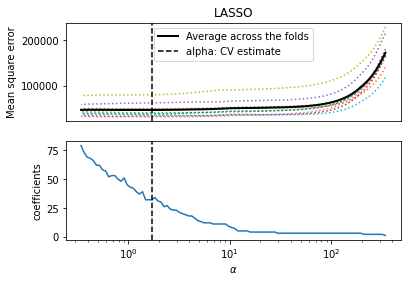

In [125]:
gs = gridspec.GridSpec(2,1)
fig = plt.figure()
ax = fig.add_subplot(gs[0])
ax.semilogx(lasso_cv.alphas_, lasso_cv.mse_path_, linestyle=":")
ax.plot(
    lasso_cv.alphas_,
    lasso_cv.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
ax.axvline(lasso_cv.alpha_, linestyle="--", color="black", label="alpha: CV estimate")
ax.set_ylabel("Mean square error")
ax.legend()
ax.set_title(
    "LASSO"
)
ax.axes.get_xaxis().set_visible(False)

ax = fig.add_subplot(gs[1], sharex=ax)
alphas_lasso, coefs_lasso, _ = lasso_path(sqft_tr_X, sqft_tr_Y,
                                          alphas=lasso_cv.alphas_,
                                          max_iter=50000)
colors = cycle(["b", "r", "g", "c", "k"])
coef_count = []
for i, _ in enumerate(alphas_lasso):
    count = 0
    for coefs in coefs_lasso:
        if coefs[i] != 0:
            count += 1
    coef_count.append(count)

ax.semilogx(alphas_lasso, coef_count)
ax.axvline(lasso_cv.alpha_, linestyle="--", color="black", label="alpha: CV estimate")
ax.set_ylabel("coefficients")
ax.set_xlabel(r"$\alpha$")
plt.show()


In [126]:
coef_idx = lasso_cv.coef_ != 0
coefficients = lasso_cv.coef_[coef_idx]
coefficients = pd.Series(coefficients, sqft_tr_X.columns[coef_idx])
coefficients.abs().sort_values(ascending=False)

beds                          2.482312e+02
bath_count_2.5                1.993574e+02
baths                         1.536840e+02
bath_count_2.0                1.204028e+02
count.pub.high_0              5.360727e+01
has.garage_False              3.635755e+01
pet.allowed_disallowed        1.991338e+01
pet.rent                      1.687642e+01
bed_count_2                   1.682195e+01
has.priv.elementary_False     1.540621e+01
neighborhood_River North      1.390008e+01
has.street_False              1.170602e+01
pet.fee                       1.151235e+01
shopping.num                  1.025168e+01
PC3                           9.279091e+00
neighborhood_Streeterville    7.847483e+00
pub.elt.mid_0                 7.797936e+00
pub.elt.mid_2                 7.414437e+00
has.lot_False                 6.538125e+00
covered.fee                   6.348815e+00
garage.fee                    6.049023e+00
priv.elt.mid.hi_1             5.506703e+00
lng                           4.933103e+00
bed_count_1

In [127]:
del coefficients["has.street_True"]
del coefficients["has.lot_True"]
del coefficients["has.garage_True"]